# Result Analysis for Deephyper Graph Neural Network
### Author: Shengli Jiang (sjiang87@wisc.edu)

### Datasets: QM7, QM8, QM9, ESOL, FreeSolv, Lipophilicity

In [14]:
import matplotlib
import lime
import lime.lime_tabular
import sklearn.model_selection
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from treeinterpreter import treeinterpreter as ti
from analysis_utils import load_json, to_sec, three_random_split, three_random_mean_std, create_csv

sns.set()
sns.set_context("talk", font_scale=1.5)
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['xtick.labelsize'] = 20
matplotlib.rcParams['ytick.labelsize'] = 20
matplotlib.rcParams['axes.labelsize'] = 20
matplotlib.rcParams['legend.title_fontsize'] = 20
matplotlib.rcParams['legend.fontsize'] = 20
matplotlib.rcParams['axes.axisbelow'] = True
matplotlib.rcParams['figure.figsize'] = [8, 6]
matplotlib.rcParams["scatter.marker"] = 'o'
matplotlib.rcParams["lines.markersize"] = 5

### 1 Generate reward vs time figure

In [22]:
def plot_reward_vs_time(data, PLOT_DIR, ylim=None, time=True, plot=False):
    start_infos = data['start_infos'][0]
    try:
        start_time = to_sec(data['workload']['times'][0])
    except:
        start_time = to_sec(start_infos['timestamp'])
    times = [to_sec(ts)-start_time for ts in data['timestamps']]
    x = times
    y = data['raw_rewards']
    plt.figure(figsize=(8.5, 6))
    if time:
        plt.plot(x, y, 'o', markersize=3)
        plt.xlabel('Time (sec)')
    else:
        plt.plot(y, 'o', markersize=3)
        plt.xlabel('Iterations')
    plt.ylabel('Reward (-MAE)')
    
    plt.xlim(left=0)
    if ylim is not None:
        plt.ylim(ylim)
    plt.locator_params(axis='y', nbins=6)
    plt.savefig(PLOT_DIR+'reward.png', dpi=300, bbox_inches='tight')
    if not plot:
        plt.close();

### 2.3 Three random split data parity plot

In [24]:
def three_random_parity_plot(DATA_DIR, PLOT_DIR, multi_class=False, limits=None, plot=False):
    _, _, _, _, y_true_raw, y_pred_raw = three_random_split(DATA_DIR, multi_class=multi_class)
    if not multi_class:
        y_true = y_true_raw.ravel()
        y_pred = y_pred_raw.ravel()
        plt.figure(figsize=(8,6))
        min_value = np.min([y_true.min(), y_pred.min()])
        max_value = np.max([y_true.max(), y_pred.max()])
        dist = max_value - min_value
        min_value -= 0.03*dist
        max_value += 0.03*dist
        if limits is not None:
            min_value, max_value = limits
        plt.plot(np.linspace(min_value, max_value, 100), np.linspace(min_value, max_value, 100), 'k--', alpha=0.5)
        plt.scatter(y_true.ravel(), y_pred.ravel(), s=5, alpha=0.9)
        plt.xlim(min_value, max_value)
        plt.ylim(min_value, max_value)
        plt.xlabel("True")
        plt.ylabel("Predicted")
        plt.axis("square")
        plt.locator_params(axis='x', nbins=5)
        plt.locator_params(axis='y', nbins=5)
        plt.savefig(PLOT_DIR + "parity_plot.png", bbox_inches='tight')
        if not plot:
            plt.close();
    else:
        for c in range(y_true_raw.shape[-1]):
            y_true = y_true_raw[..., c].ravel()
            y_pred = y_pred_raw[..., c].ravel()
            plt.figure(figsize=(8,6))
            min_value = np.min([y_true.min(), y_pred.min()])
            max_value = np.max([y_true.max(), y_pred.max()])
            dist = max_value - min_value
            min_value -= 0.03*dist
            max_value += 0.03*dist
            if limits is not None:
                min_value, max_value = limits
            plt.plot(np.linspace(min_value, max_value, 100), np.linspace(min_value, max_value, 100), 'k--', alpha=0.5)
            plt.scatter(y_true.ravel(), y_pred.ravel(), s=5, alpha=0.9)
            plt.xlim(min_value, max_value)
            plt.ylim(min_value, max_value)
            plt.xlabel("True")
            plt.ylabel("Predicted")
            plt.axis("square")
            plt.locator_params(axis='x', nbins=5)
            plt.locator_params(axis='y', nbins=5)
            plt.savefig(PLOT_DIR + f"parity_plot_{c}.png", bbox_inches='tight')
            if not plot:
                plt.close();

### 3.1 CSV file to feature importance

In [27]:
def feature_importance(DATA_DIR, PLOT_DIR, plot=False):
    train_data = pd.read_csv(DATA_DIR + 'nas_result.csv', header=None)
    df = train_data
    df_new = pd.DataFrame()
    for i in range(df.shape[1]):
        if (df.dtypes[i] == 'object'):
            vals = pd.get_dummies(df.iloc[:,i])
        else:
            vals = df.iloc[:,i]
        df_new = pd.concat([df_new.reset_index(drop=True), vals.reset_index(drop=True)], axis=1)
    X = df_new.iloc[:, :-1]
    y = df_new.iloc[:, -1]
    scaler = StandardScaler()
    y = scaler.fit_transform(y.values[..., np.newaxis]).squeeze()
    reg = RandomForestRegressor(n_estimators=100, random_state=0).fit(X.values, y)
    
    prediction, bias, contributions = ti.predict(reg, X.values)
    mask = np.copy(X.values)
    mask = mask.astype(float)
    mask[mask==0] = -1
    importance = np.multiply(contributions, mask)
    importance = importance.mean(axis=0)
    importance = importance / np.max(np.abs(importance))
    indices = np.argsort(importance)[-10:] 
    indices_neg = np.argsort(importance)[:10] 
    plt.figure(figsize=(12,6))
    plt.barh(range(10, 20), importance[indices], align='center')
    plt.barh(range(10), importance[indices_neg], align='center')
    plt.yticks(range(20), [X.columns[i] for i in indices_neg] + [X.columns[i] for i in indices] )
    plt.xlabel('Relative Importance')
    plt.tight_layout()
    plt.savefig(PLOT_DIR + 'feature_importance.png', dpi=300, bbox_inches='tight')
    if not plot:
        plt.close()

### 4.1 MoleculeNet vs Deephyeper

In [26]:
def mol_vs_deep(DATA_DIR, PLOT_DIR, mol_m, mol_s, metric='MAE', plot=False):
    m, s = three_random_mean_std(DATA_DIR=DATA_DIR)
    labels = ["Train", "Valid", "Test"]
    if metric is 'MAE':
        m = m[:3]
        s = s[:3]
    if metric is 'MSE':
        m = m[3:6]
        s = s[3:6]
    plt.figure()
    plt.barh([0.25,-1.75,-3.75], m, color="maroon", align='center', height=0.5, label="Deephyper", xerr=s, capsize=5)
    plt.barh([-0.25,-2.25,-4.25], mol_m, color="gray", align='center', height=0.5, label="MoleculeNet", xerr=mol_s, capsize=5)
    plt.yticks([0,-2,-4], labels)
    plt.xlabel(f"{metric}")
    plt.legend(loc=1)
    plt.savefig(PLOT_DIR + f"{metric}_compare.png", dpi=300, bbox_inches='tight')
    if not plot:
        plt.close();

# QM7

In [28]:
QM7_PLOT_DIR = r"/mnt/d/plots/anl/qm7/"
QM7_DATA_DIR = r"/mnt/d/machinelearning2/ANL/qm7/run_0721/"
QM7_data = load_json(QM7_DATA_DIR + 'data_2020-07-25_03.json')

       MAE               MSE                    R2
-----  ----------------  ---------------------  ---------------
Train  39.8414+/-0.8927  11406.9857+/-315.7167  0.7739+/-0.0063
Valid  41.5313+/-0.3054  11872.5280+/-27.8721   0.7365+/-0.0006
Test   38.4765+/-0.0840  10726.3597+/-66.6328   0.7760+/-0.0014


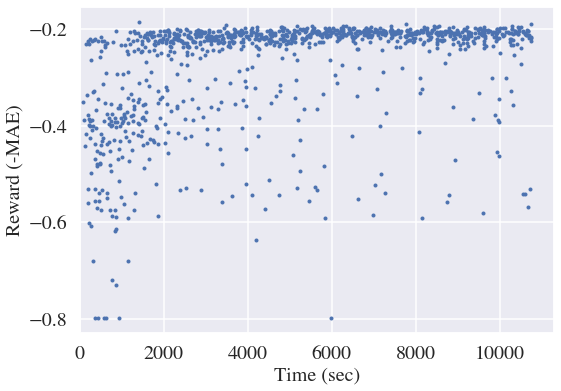

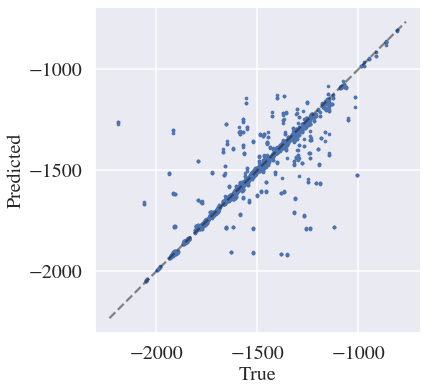

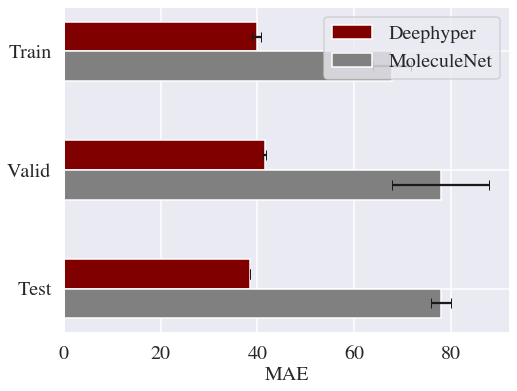

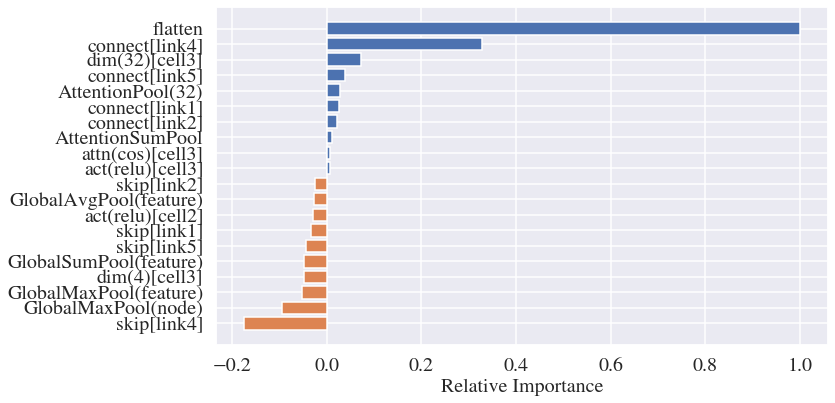

In [29]:
plot_reward_vs_time(QM7_data, QM7_PLOT_DIR, plot=True)
three_random_parity_plot(QM7_DATA_DIR, QM7_PLOT_DIR, plot=True)
mol_vs_deep(QM7_DATA_DIR, QM7_PLOT_DIR, [67.8, 77.9, 77.9], [4.0, 10.0, 2.1], metric='MAE', plot=True)
create_csv(QM7_DATA_DIR, QM7_data)
feature_importance(QM7_DATA_DIR, QM7_PLOT_DIR, plot=True)

# QM8

In [33]:
QM8_PLOT_DIR = r"/mnt/d/plots/anl/qm8/"
QM8_DATA_DIR = r"/mnt/d/machinelearning2/ANL/qm8/run_0721/"
QM8_data = load_json(QM8_DATA_DIR + 'data_2020-07-25_14.json')

       MAE              MSE              R2
-----  ---------------  ---------------  ---------------
Train  0.0084+/-0.0003  0.0004+/-0.0000  0.9661+/-0.0027
Valid  0.0122+/-0.0001  0.0008+/-0.0000  0.9347+/-0.0028
Test   0.0123+/-0.0001  0.0009+/-0.0000  0.9327+/-0.0021


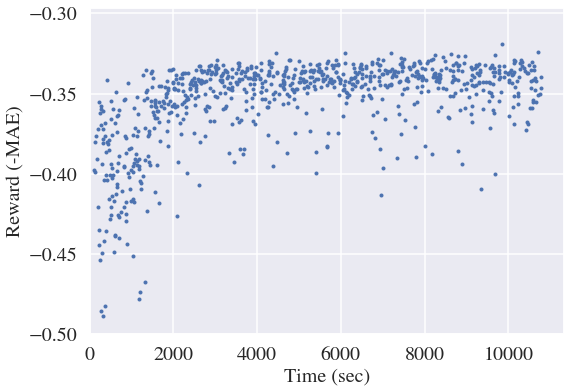

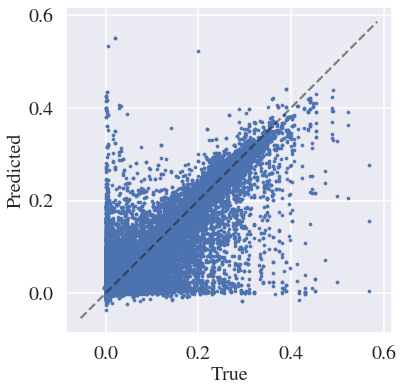

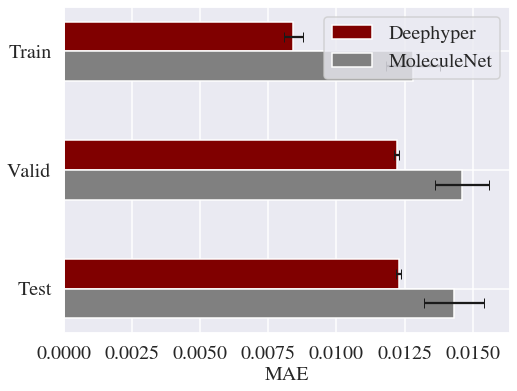

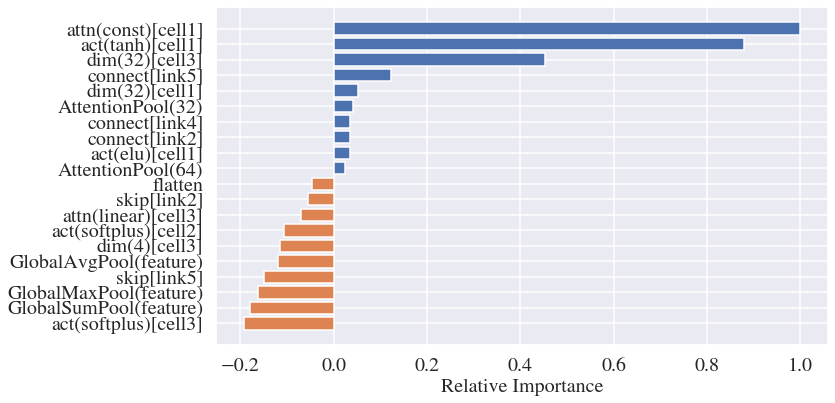

In [34]:
plot_reward_vs_time(QM8_data, QM8_PLOT_DIR, ylim=[-0.5, None], plot=True)
three_random_parity_plot(QM8_DATA_DIR, QM8_PLOT_DIR, plot=True)
three_random_parity_plot(QM8_DATA_DIR, QM8_PLOT_DIR, multi_class=True, plot=False)
# three_random_mean_std(QM8_DATA_DIR, multi_class=True)
mol_vs_deep(QM8_DATA_DIR, QM8_PLOT_DIR, [0.0128, 0.0146, 0.0143], [0.001, 0.001, 0.0011], metric='MAE', plot=True)
create_csv(QM8_DATA_DIR, QM8_data)
feature_importance(QM8_DATA_DIR, QM8_PLOT_DIR, plot=True)

## QM9

In [35]:
QM9_PLOT_DIR = r"/mnt/d/plots/anl/qm9/"
QM9_DATA_DIR = r"/mnt/d/machinelearning2/ANL/qm9/run_0721/"
QM9_data = load_json(QM9_DATA_DIR + 'data_2020-07-24_04.json')

       MAE              MSE                R2
-----  ---------------  -----------------  ---------------
Train  4.7401+/-0.0000  473.9075+/-0.0000  0.9974+/-0.0000
Valid  4.4709+/-0.0000  441.0853+/-0.0000  0.9976+/-0.0000
Test   4.4593+/-0.0000  419.5709+/-0.0000  0.9977+/-0.0000


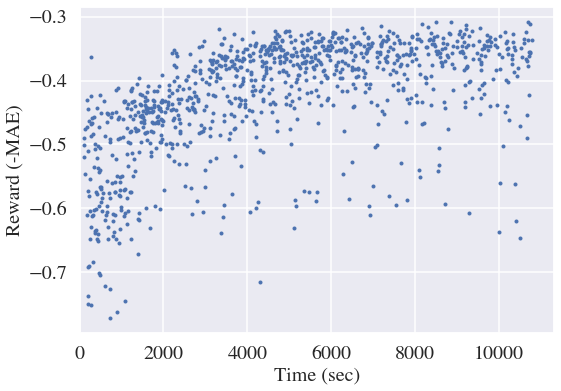

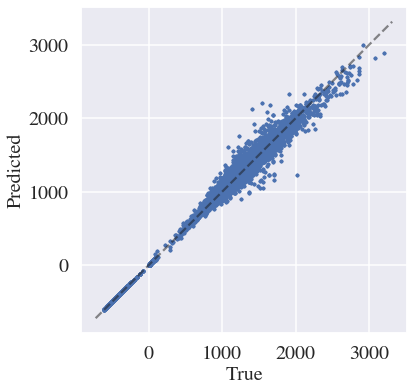

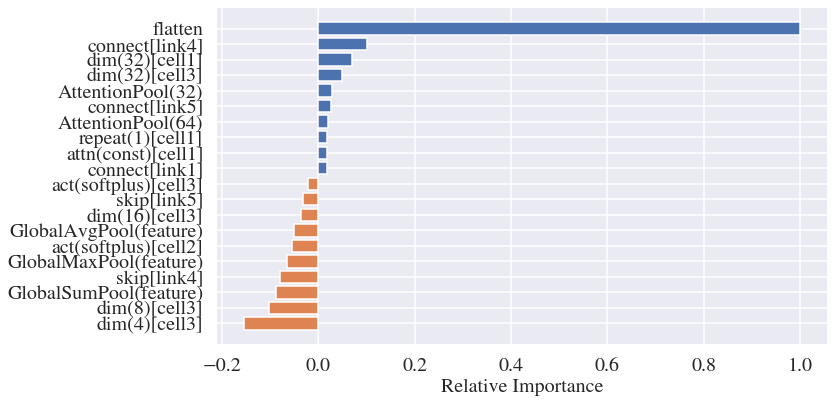

In [36]:
plot_reward_vs_time(QM9_data, QM9_PLOT_DIR, plot=True)
three_random_parity_plot(QM9_DATA_DIR, QM9_PLOT_DIR, plot=True)
three_random_parity_plot(QM9_DATA_DIR, QM9_PLOT_DIR, multi_class=True, plot=False)
# three_random_mean_std(QM9_DATA_DIR, multi_class=True)
mol_vs_deep(QM9_DATA_DIR, QM9_PLOT_DIR, [2.3, 2.4, 2.4], [1.1, 1.1, 1.1], metric='MAE')
create_csv(QM9_DATA_DIR, QM9_data)
feature_importance(QM9_DATA_DIR, QM9_PLOT_DIR, plot=True)

# ESOL

In [37]:
ESOL_PLOT_DIR = r"/mnt/d/plots/anl/ESOL/"
ESOL_DATA_DIR = r"/mnt/d/machinelearning2/ANL/ESOL/run_0721/"
ESOL_data = load_json(ESOL_DATA_DIR + 'data_2020-07-24_13.json')

       MAE              MSE              R2
-----  ---------------  ---------------  ---------------
Train  0.2865+/-0.0236  0.1403+/-0.0256  0.9680+/-0.0059
Valid  0.4673+/-0.0212  0.3945+/-0.0064  0.9153+/-0.0014
Test   0.4015+/-0.0134  0.2867+/-0.0064  0.9310+/-0.0015


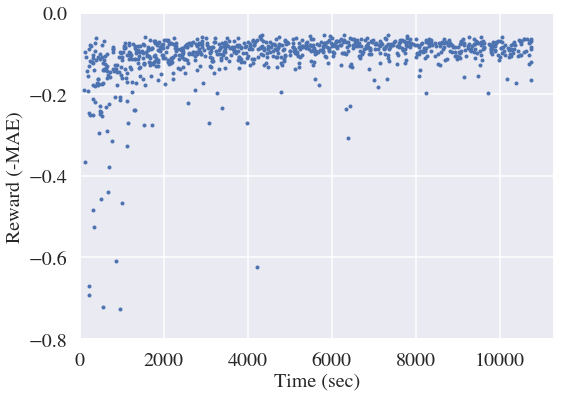

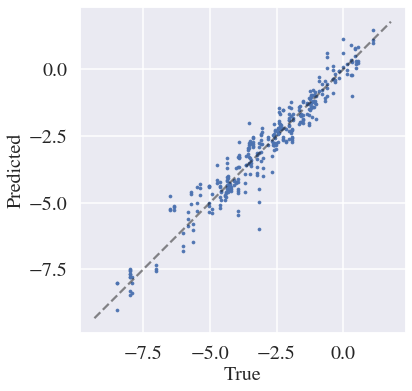

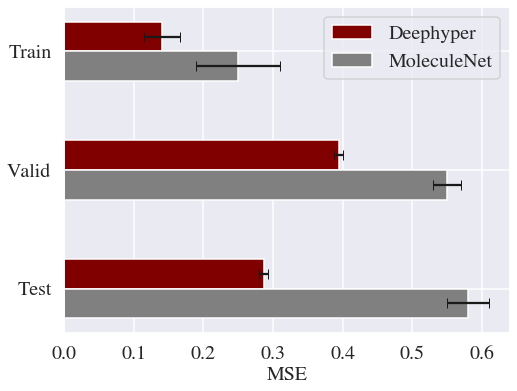

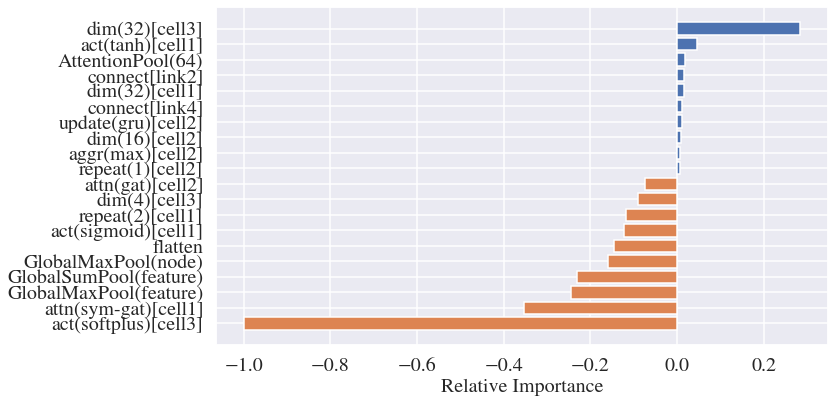

In [38]:
plot_reward_vs_time(ESOL_data, ESOL_PLOT_DIR, ylim=[-0.8, 0], plot=True)
three_random_parity_plot(ESOL_DATA_DIR, ESOL_PLOT_DIR, plot=True)
mol_vs_deep(ESOL_DATA_DIR, ESOL_PLOT_DIR, [0.25, 0.55, 0.58], [0.06, 0.02, 0.03], metric='MSE', plot=True)
create_csv(ESOL_DATA_DIR, ESOL_data)
feature_importance(ESOL_DATA_DIR, ESOL_PLOT_DIR, plot=True)

## FreeSolv

In [40]:
FreeSolv_PLOT_DIR = r"/mnt/d/plots/anl/FreeSolv/"
FreeSolv_DATA_DIR = r"/mnt/d/machinelearning2/ANL/FreeSolv/run_0721_extra/"
FreeSolv_data = load_json(FreeSolv_DATA_DIR + 'data_2020-07-24_13.json')

       MAE              MSE              R2
-----  ---------------  ---------------  ---------------
Train  0.4371+/-0.1182  0.4434+/-0.2670  0.9696+/-0.0183
Valid  0.5535+/-0.0081  0.6791+/-0.0263  0.9609+/-0.0015
Test   0.6871+/-0.0485  1.4828+/-0.0079  0.8883+/-0.0006


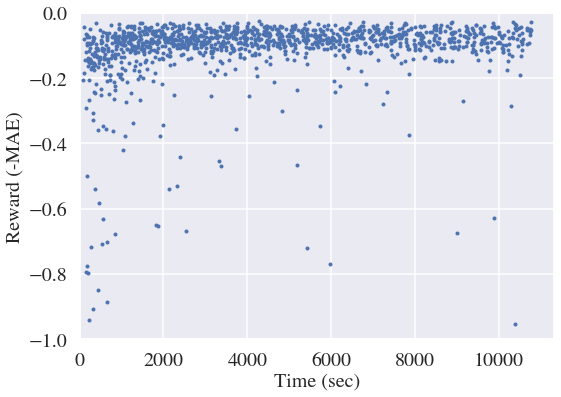

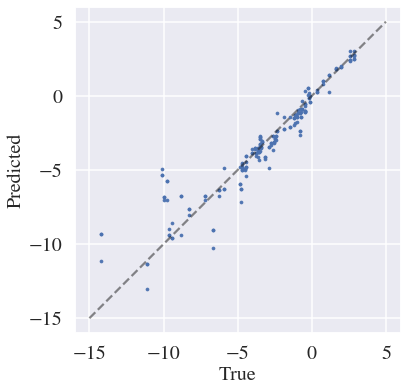

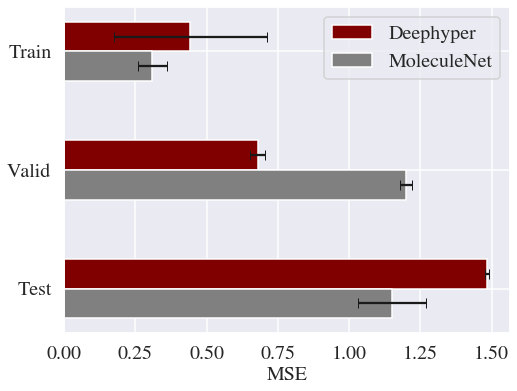

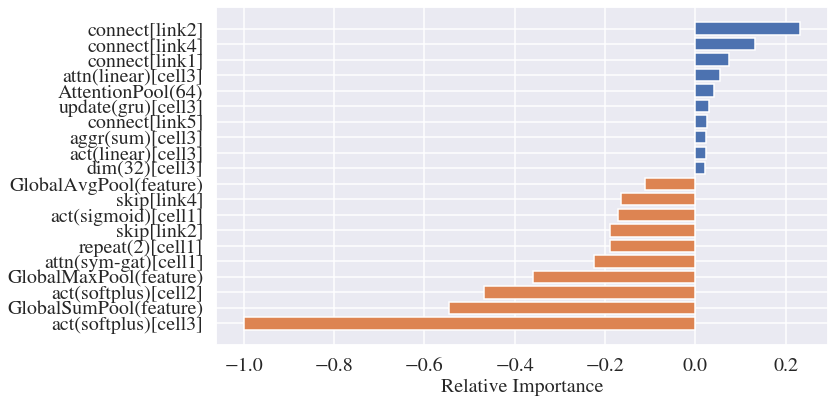

In [41]:
plot_reward_vs_time(FreeSolv_data, FreeSolv_PLOT_DIR, ylim=[-1.0, 0], plot=True)
three_random_parity_plot(FreeSolv_DATA_DIR, FreeSolv_PLOT_DIR, limits=(-15, 5), plot=True)
mol_vs_deep(FreeSolv_DATA_DIR, FreeSolv_PLOT_DIR, [0.31, 1.20, 1.15], [0.05, 0.02, 0.12], metric='MSE', plot=True)
create_csv(FreeSolv_DATA_DIR, FreeSolv_data)
feature_importance(FreeSolv_DATA_DIR, FreeSolv_PLOT_DIR, plot=True)

## Lipophilicity

In [42]:
LIPO_PLOT_DIR = r"/mnt/d/plots/anl/Lipo/"
LIPO_DATA_DIR = r"/mnt/d/machinelearning2/ANL/Lipo/run_0721/"
LIPO_data = load_json(LIPO_DATA_DIR + 'data_2020-07-21_14.json')

       MAE              MSE              R2
-----  ---------------  ---------------  ---------------
Train  0.3871+/-0.0377  0.2572+/-0.0441  0.8185+/-0.0311
Valid  0.4550+/-0.0148  0.3656+/-0.0183  0.7620+/-0.0119
Test   0.4678+/-0.0371  0.3598+/-0.0514  0.7728+/-0.0324


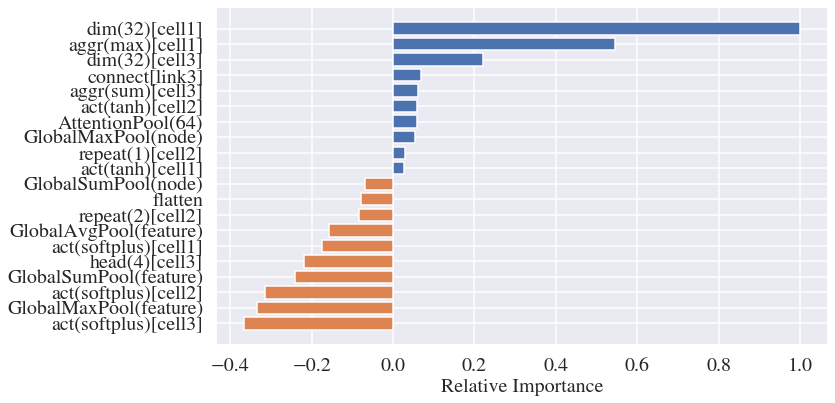

In [43]:
plot_reward_vs_time(LIPO_data, LIPO_PLOT_DIR, ylim=[-1.5, None], plot=False)
three_random_parity_plot(LIPO_DATA_DIR, LIPO_PLOT_DIR, plot=False)
mol_vs_deep(LIPO_DATA_DIR, LIPO_PLOT_DIR, [0.471, 0.678, 0.655], [0.001, 0.04, 0.036], metric='MSE', plot=False)
create_csv(LIPO_DATA_DIR, LIPO_data)
feature_importance(LIPO_DATA_DIR, LIPO_PLOT_DIR, plot=True)